In [26]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Import Libraries**

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers 
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as k 
from sklearn.preprocessing import StandardScaler, normalize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from PIL import Image
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.activations import softmax, relu
from keras.initializers import VarianceScaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [28]:
train=os.path.join("/kaggle/input/brain-tumor-mri-dataset/Training/")
test= os.path.join("/kaggle/input/brain-tumor-mri-dataset/Testing/")

# Data Augmentation

In [29]:
train_data= ImageDataGenerator(
    rescale= 1/255,
    zoom_range=0.2,
    rotation_range= 20,
    shear_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_data= ImageDataGenerator(
    rescale= 1/255
)

In [55]:
Img_width=28
Img_height=28

train_gen= train_data.flow_from_directory(
    train,
    target_size= (224,224),
    batch_size=32,
    class_mode='categorical',
)


val_gen = test_data.flow_from_directory(
    test,
    target_size= (224,224),
    batch_size=32,
    class_mode='categorical',         
)

test_gen = test_data.flow_from_directory(
    test,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False   # VERY IMPORTANT
)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


# CNN Model

In [31]:
resnet=tf.keras.applications.ResNet50V2(weights ="imagenet", input_shape=(224,224,3),pooling="max" , classes =4 , include_top=False)

In [32]:
for layer in resnet.layers:
    layer.trainable = False

In [33]:
resnet_model = Sequential()

In [34]:
resnet_model.add(resnet)

In [35]:
resnet_model.add(Flatten())
resnet_model.add(Dense(64, activation ="relu"))
resnet_model.add(Dense(32, activation ="relu"))
resnet_model.add(Dense(4, activation ="softmax"))

In [36]:
for layer in resnet.layers:
    layer.trainable = False

# Traning Model

In [37]:
resnet_model.compile(
    optimizer = "adam",
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

In [38]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop= EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    restore_best_weights=True
)

In [39]:
resnet_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,698,148 (90.40 MB)

 Trainable params: 133,348 (520.89 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [40]:
history = resnet_model.fit(train_gen , epochs =20 , validation_data = val_gen , callbacks=[early_stop])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 82s 399ms/step - accuracy: 0.6056 - loss: 1.5114 - val_accuracy: 0.8162 - val_loss: 0.5067
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 64s 359ms/step - accuracy: 0.8468 - loss: 0.4105 - val_accuracy: 0.8604 - val_loss: 0.4177
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 65s 361ms/step - accuracy: 0.8773 - loss: 0.3425 - val_accuracy: 0.8871 - val_loss: 0.3275
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 64s 359ms/step - accuracy: 0.8824 - loss: 0.3109 - val_accuracy: 0.8291 - val_loss: 0.4493
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 65s 361ms/step - accuracy: 0.9042 - loss: 0.2577 - val_accuracy: 0.8970 - val_loss: 0.2812
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 67s 374ms/step - accuracy: 0.9170 - loss: 0.2202 - val_accuracy: 0.8993 - val_loss: 0.2839
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 64s 359ms/step - accuracy: 0.9076 - loss: 0.2440 - val_accuracy: 0.8802 - val_loss: 0.3942
Epoch 8/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 65s 362ms/step - accuracy: 0.9199 - loss: 0

# Model Evaluation

In [41]:
Test_Acc = resnet_model.evaluate(test_gen)

print("Testing Accuracy : ", Test_Acc[1]*100, "%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.9379 - loss: 0.1701
Testing Accuracy :  93.6689555644989 %


# Visualization

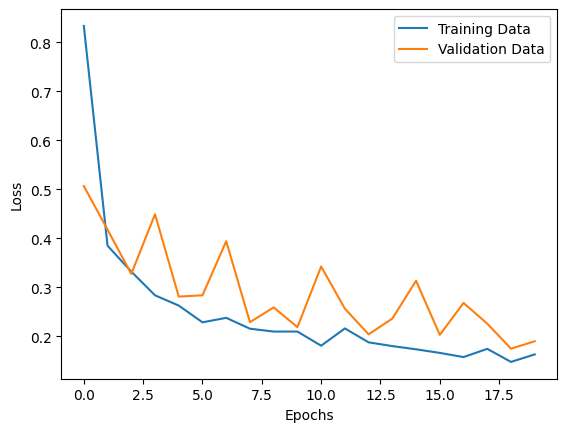

In [42]:
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.plot(history.history['loss'], label = 'Training Data')
plt.plot(history.history['val_loss'], label = 'Validation Data')

plt.legend()
plt.show()

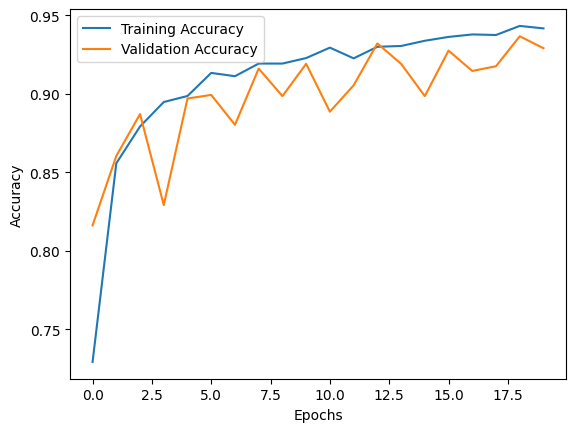

In [43]:
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.legend()
plt.show()


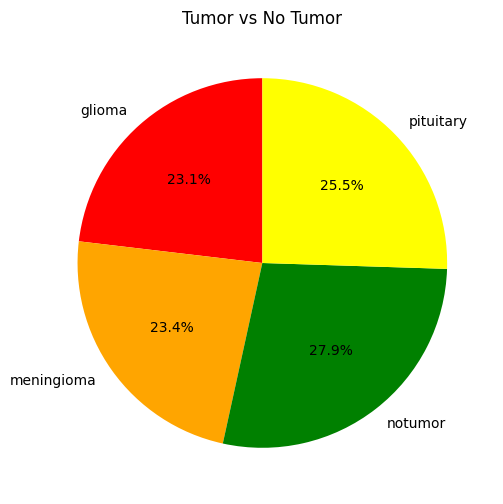

In [44]:
class_names = list(train_gen.class_indices.keys())

counts = np.bincount(train_gen.classes)

plt.figure(figsize=(6,6))
plt.pie(counts, labels=class_names, autopct='%1.1f%%', startangle=90, colors=['red','orange','green','yellow'])
plt.title("Tumor vs No Tumor")
plt.show()


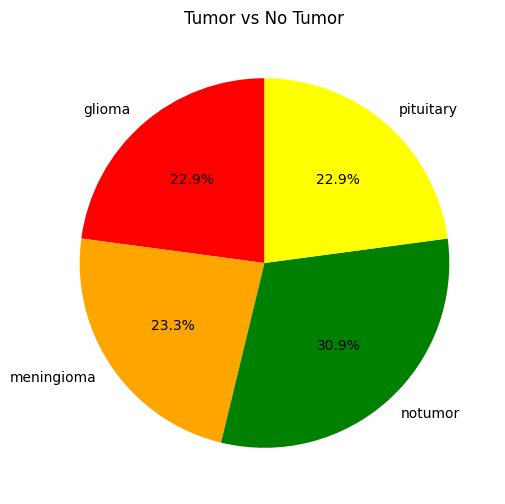

In [45]:
class_names = list(test_gen.class_indices.keys())

counts = np.bincount(test_gen.classes)

plt.figure(figsize=(6,6))
plt.pie(counts, labels=class_names, autopct='%1.1f%%', startangle=90, colors=['red','orange','green','yellow'])
plt.title("Tumor vs No Tumor")
plt.show()


 # confusion matrix

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step
Classification Report
              precision    recall  f1-score   support

      glioma       0.93      0.90      0.92       300
  meningioma       0.87      0.90      0.88       306
     notumor       0.99      0.98      0.98       405
   pituitary       0.94      0.96      0.95       300

    accuracy                           0.94      1311
   macro avg       0.93      0.93      0.93      1311
weighted avg       0.94      0.94      0.94      1311



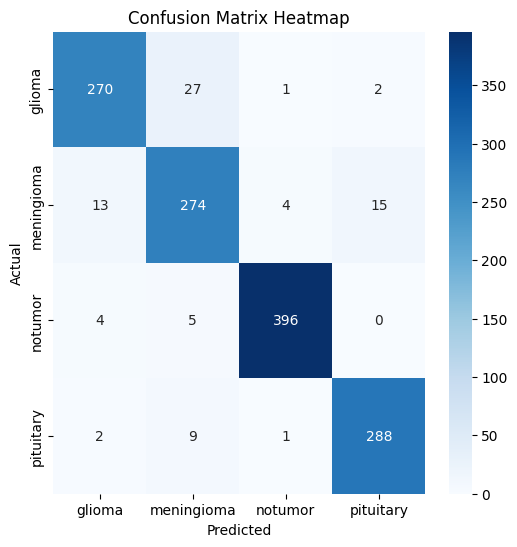

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# True labels
y_test = test_gen.classes  

# Predictions
raw_pred = resnet_model.predict(test_gen)
pred = np.argmax(raw_pred, axis=1)

# Class labels
class_labels = list(test_gen.class_indices.keys())

# Classification report
print("Classification Report")
print(classification_report(y_test, pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_test, pred)

# Plot Confusion Matrix as Heatmap
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()
